In [4]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
import subprocess
from PIL import Image
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pprint import pprint
from tqdm import tqdm, tqdm_notebook

random.seed(165)

In [5]:
# DATA_PATH = "/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*"
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*" # <- needs to be normalized
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*" # <- needs to be normalized
DATA_PATH = "/home/satyarth934/data/nasa_impact/hurricanes/*/*"
MODEL_NAME = "baseAE_hurricane_try3"
BASE_DIR = "/home/satyarth934/code/FDL_2020/"
NORMALIZE = True
SAVE_FILES = True

OUTPUT_MODEL_PATH = BASE_DIR + "Models/" + MODEL_NAME
TENSORBOARD_LOG_DIR = BASE_DIR + "tb_logs/" + MODEL_NAME
ACTIVATION_IMG_PATH = BASE_DIR + "activation_viz/" + MODEL_NAME

FEATURES_PARENT_DIR = BASE_DIR + "Features/" + MODEL_NAME
PATH_LIST = FEATURES_PARENT_DIR + "/filenames1819.pkl"
FEATURES_OUTPUT = FEATURES_PARENT_DIR + "/features1819.pkl"

# NUM_EPOCHS = 200

# dust_labels = {0: "Dust", 1: "Hazy", 2: "No Dust"}

In [6]:
X_test_paths = pickle.load(file=open((PATH_LIST), 'rb'))
feature_list = pickle.load(file=open((FEATURES_OUTPUT), 'rb'))

In [7]:
num_images = len(X_test_paths)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  2623
Number of features per image =  3920


In [8]:
# Use scikit-learn to find Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=50,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

In [18]:
# wind_speed in knots
def getCategory(wind_speed):
    if wind_speed <= 33:
        return 'TD'
    elif 34 <= wind_speed <= 63:
        return 'TS'
    elif 64 <= wind_speed <= 82:
        return 'C1'
    elif 83 <= wind_speed <= 95:
        return 'C2'
    elif 96 <= wind_speed <= 112:
        return 'C3'
    elif 113 <= wind_speed <= 136:
        return 'C4'
    elif wind_speed >= 137:
        return 'C5'


def classname(str):    
    file_name = str.split("/")[-1]
    wind_speed = int(file_name.split(".")[0].split("_")[-1].strip("kts"))
    return getCategory(wind_speed)


# Helper function to get the classname and filename
def classname_filename(filepath):
    file_name = filepath.split("/")[-1]
    return str(classname(filepath)) + '/' + file_name.split("_")[0] + "_" + file_name.split("_")[-1]


# Normalize the image to plot
def normalize(mat):
    normalized = (mat - np.nanmin(mat)) / (np.nanmax(mat) - np.nanmin(mat))
    return normalized


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances, dims):
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, filename in enumerate(filenames):
        image = resize(plt.imread((filename))[:,:,:3], dims)
        if NORMALIZE:
            image = normalize(image)
        
        ax = plt.subplot(len(filenames) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        ax.imshow(image)

#     plt.imshow(image)
    # To save the plot in a high definition format i.e. PDF, uncomment the following line:
    if SAVE_FILES:
        file_parent = BASE_DIR + "Features/Images/" + MODEL_NAME
        subprocess.call("mkdir -p " + file_parent, shell=True)
        output_path = file_parent + "/similar_%s_%s.png" % (filenames[i].split('/')[-1].split(".")[0], classname(filenames[i]))
        plt.savefig(output_path)
        plt.savefig(output_path.replace(".png", ".eps"))
    # We will use this line repeatedly in our code.

  0%|          | 0/20 [00:00<?, ?it/s]

2022
[2022  245  836  309  384 2244  870 1498 1399 2082 1780 2294 2409  137
  688]
[0.0, 0.68, 0.69, 0.7, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.72, 0.73, 0.74, 0.74, 0.74]
['ep162018_advTime_20180829T180000_goesTime_20180829T202056_intensity_65kts.png',
 'ep132019_advTime_20190918T180000_goesTime_20190918T182505_intensity_55kts.png',
 'ep172018_advTime_20180904T120000_goesTime_20180904T132054_intensity_90kts.png',
 'ep082018_advTime_20180726T120000_goesTime_20180726T152058_intensity_30kts.png']


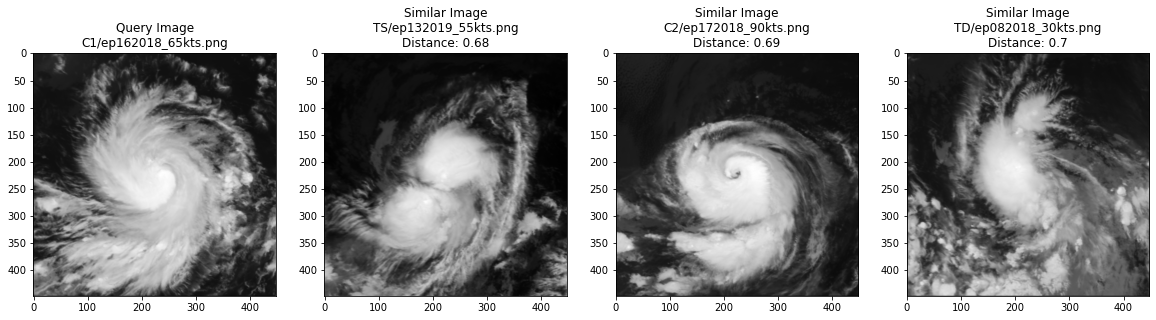

  5%|▌         | 1/20 [00:02<00:40,  2.15s/it]

958
[ 958  785 2580 2532  199  312   96  409 1708 2110  302  239 2558 1892
 1844]
[0.0, 0.44, 0.44, 0.44, 0.44, 0.44, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.46, 0.46, 0.47]
['al022018_advTime_20180712T060000_goesTime_20180712T112103_intensity_25kts.png',
 'al042019_advTime_20190823T060000_goesTime_20190823T102508_intensity_25kts.png',
 'al102018_advTime_20180920T180000_goesTime_20180920T202051_intensity_20kts.png',
 'al042019_advTime_20190823T120000_goesTime_20190823T142508_intensity_25kts.png']


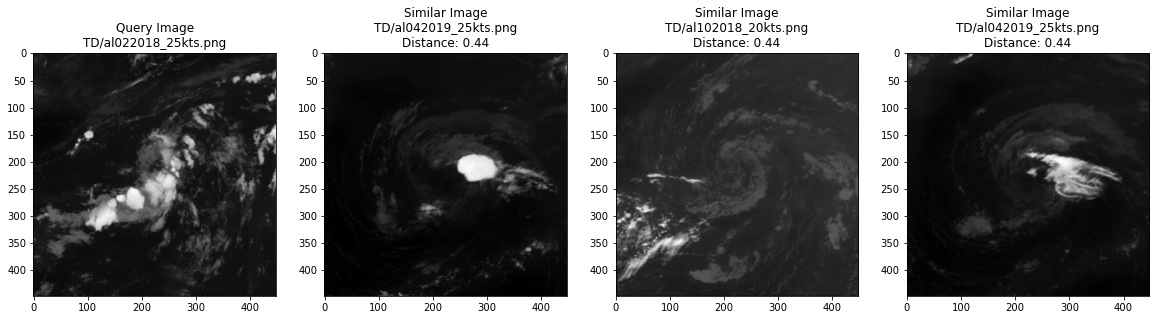

 10%|█         | 2/20 [00:04<00:38,  2.14s/it]

720
[ 720 2399 1563   10  477 1972 1700 1716  500 1244 1778  607 2172 1529
 2051]
[0.0, 0.56, 0.58, 0.67, 0.7, 0.71, 0.72, 0.72, 0.72, 0.72, 0.72, 0.73, 0.73, 0.74, 0.74]
['al122019_advTime_20190922T000000_goesTime_20190922T022506_intensity_30kts.png',
 'al122019_advTime_20190922T060000_goesTime_20190922T062506_intensity_35kts.png',
 'al122019_advTime_20190922T000000_goesTime_20190922T002506_intensity_30kts.png',
 'al122019_advTime_20190922T060000_goesTime_20190922T102506_intensity_35kts.png']


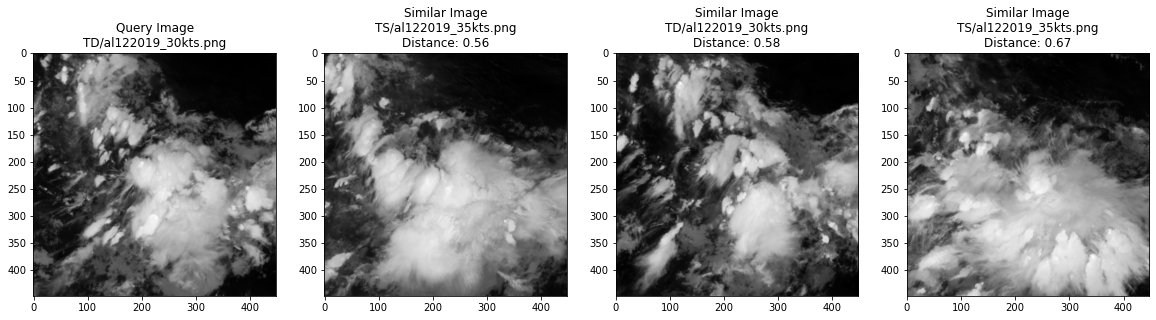

 15%|█▌        | 3/20 [00:06<00:36,  2.16s/it]

1758
[1758  674 1788  260 1380 1626  758 1996  397 1516 2559 2566 1552 1366
  598]
[0.0, 0.48, 0.49, 0.5, 0.52, 0.52, 0.53, 0.53, 0.55, 0.56, 0.56, 0.57, 0.57, 0.57, 0.57]
['al092019_advTime_20190912T120000_goesTime_20190912T172502_intensity_25kts.png',
 'al092019_advTime_20190912T180000_goesTime_20190912T202502_intensity_25kts.png',
 'al022018_advTime_20180710T000000_goesTime_20180710T002101_intensity_35kts.png',
 'al022018_advTime_20180710T000000_goesTime_20180710T022101_intensity_35kts.png']


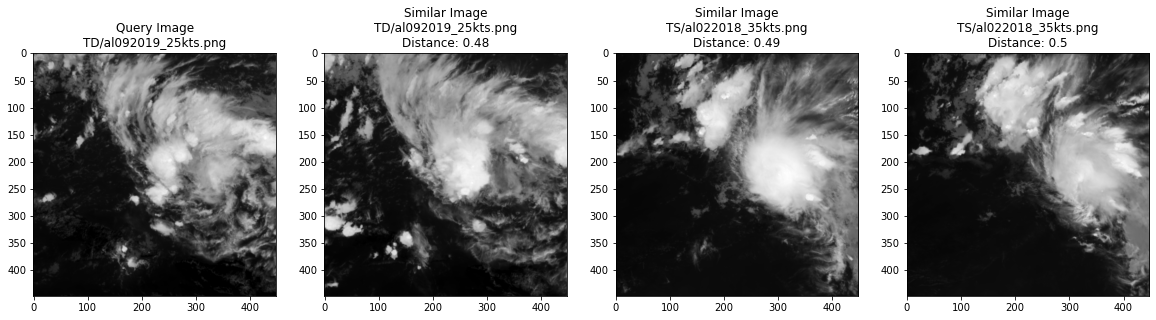

 20%|██        | 4/20 [00:08<00:35,  2.19s/it]

1291
[1291  315 1578  816  932 1567 1717 1870  801 1183  928  857 1789  466
 1723]
[0.0, 0.55, 0.55, 0.55, 0.57, 0.57, 0.57, 0.58, 0.6, 0.6, 0.61, 0.61, 0.61, 0.61, 0.61]
['ep032018_advTime_20180613T120000_goesTime_20180613T172059_intensity_60kts.png',
 'al132018_advTime_20181010T120000_goesTime_20181010T132057_intensity_65kts.png',
 'al132018_advTime_20181002T060000_goesTime_20181002T092055_intensity_55kts.png',
 'al132018_advTime_20181010T060000_goesTime_20181010T072057_intensity_65kts.png']


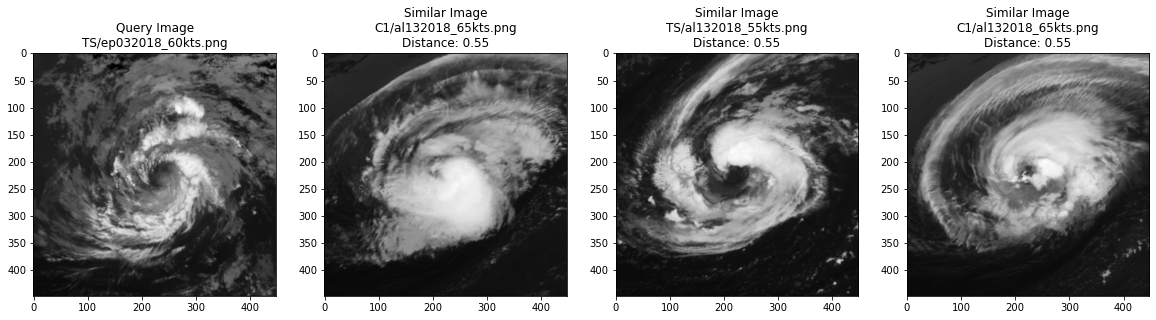

 25%|██▌       | 5/20 [00:10<00:32,  2.18s/it]

2380
[2380 1881  487 1425  102  202  502  546  598 1422 2408 2585 2532  460
 1269]
[0.0, 0.38, 0.38, 0.38, 0.39, 0.4, 0.4, 0.41, 0.41, 0.41, 0.42, 0.42, 0.42, 0.43, 0.44]
['al102018_advTime_20180914T060000_goesTime_20180914T102049_intensity_35kts.png',
 'al102018_advTime_20180916T180000_goesTime_20180916T232049_intensity_30kts.png',
 'al102018_advTime_20180916T000000_goesTime_20180916T052049_intensity_35kts.png',
 'al102018_advTime_20180916T060000_goesTime_20180916T102049_intensity_35kts.png']


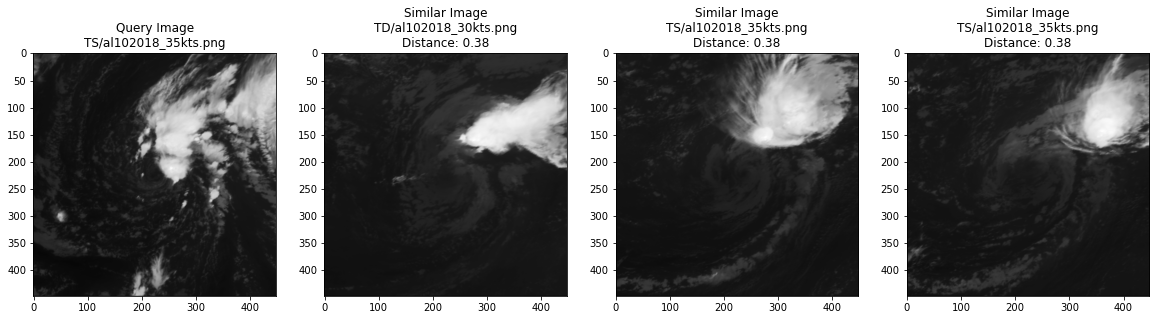

 30%|███       | 6/20 [00:13<00:30,  2.19s/it]

1982
[1982 1017 2294  688  627 1658   82  900  471 1616 1166 2130 1602   68
 1551]
[0.0, 0.55, 0.73, 0.73, 0.77, 0.78, 0.78, 0.78, 0.79, 0.79, 0.79, 0.79, 0.79, 0.8, 0.8]
['ep152019_advTime_20190919T060000_goesTime_20190919T092505_intensity_65kts.png',
 'ep152019_advTime_20190919T060000_goesTime_20190919T082505_intensity_65kts.png',
 'al102019_advTime_20190917T180000_goesTime_20190917T222504_intensity_30kts.png',
 'al102019_advTime_20190917T180000_goesTime_20190917T232504_intensity_30kts.png']


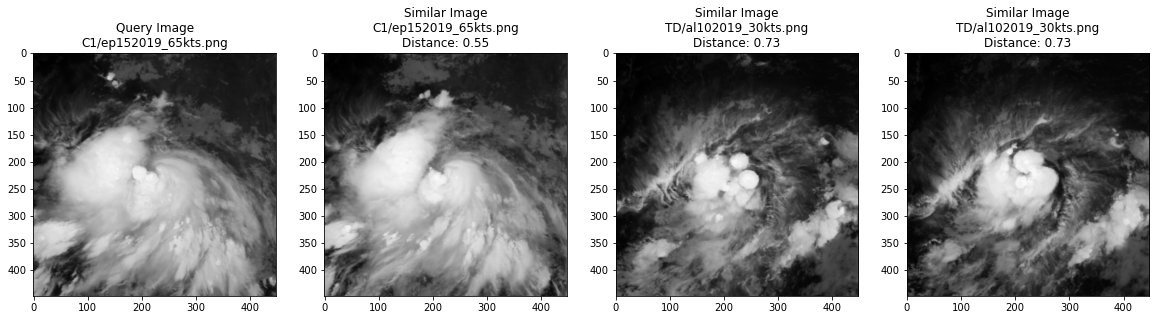

 35%|███▌      | 7/20 [00:15<00:28,  2.18s/it]

238
[ 238  583 1047 1109 1402  558  287 1135   18 1110  192  789  626  200
 1920]
[0.0, 0.25, 0.27, 0.29, 0.3, 0.3, 0.3, 0.31, 0.31, 0.31, 0.31, 0.31, 0.31, 0.32, 0.33]
['ep182018_advTime_20180913T060000_goesTime_20180913T082049_intensity_25kts.png',
 'ep182018_advTime_20180913T060000_goesTime_20180913T112049_intensity_25kts.png',
 'ep182018_advTime_20180913T000000_goesTime_20180913T052049_intensity_25kts.png',
 'ep182018_advTime_20180912T120000_goesTime_20180912T162049_intensity_25kts.png']


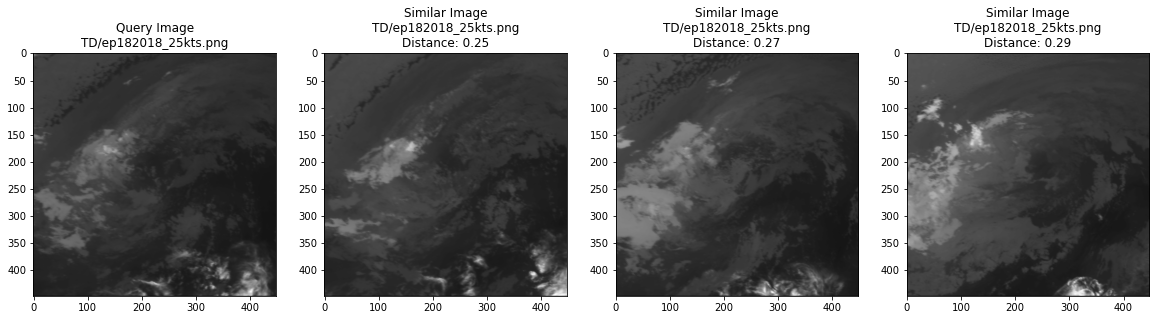

 40%|████      | 8/20 [00:17<00:26,  2.18s/it]

812
[ 812 2549 2130  900 1616 1166 2542 2268 1341  231 1235 2027 2591  525
  106]
[0.0, 0.47, 0.63, 0.64, 0.66, 0.67, 0.68, 0.69, 0.69, 0.69, 0.69, 0.7, 0.71, 0.71, 0.72]
['ep102019_advTime_20190821T180000_goesTime_20190821T182506_intensity_40kts.png',
 'ep102019_advTime_20190821T120000_goesTime_20190821T172506_intensity_35kts.png',
 'ep092018_advTime_20180726T180000_goesTime_20180726T212058_intensity_30kts.png',
 'ep092018_advTime_20180726T180000_goesTime_20180726T202058_intensity_30kts.png']


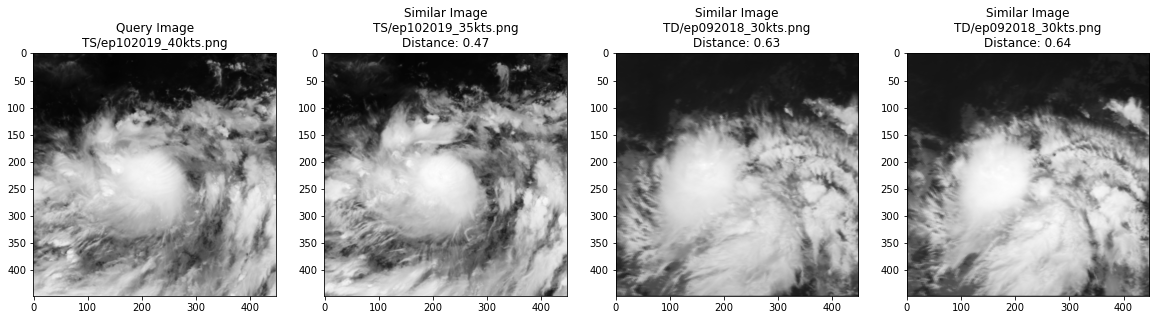

 45%|████▌     | 9/20 [00:19<00:23,  2.17s/it]

274
[ 274  810  520  752  765  929  488  414  192 2586  920 2568 1800 1472
 2198]
[0.0, 0.17, 0.19, 0.23, 0.25, 0.25, 0.26, 0.26, 0.29, 0.31, 0.32, 0.33, 0.33, 0.33, 0.33]
['ep252018_advTime_20181108T000000_goesTime_20181108T042054_intensity_25kts.png',
 'ep252018_advTime_20181108T000000_goesTime_20181108T002054_intensity_25kts.png',
 'ep252018_advTime_20181107T120000_goesTime_20181107T172054_intensity_25kts.png',
 'ep252018_advTime_20181107T060000_goesTime_20181107T082055_intensity_25kts.png']


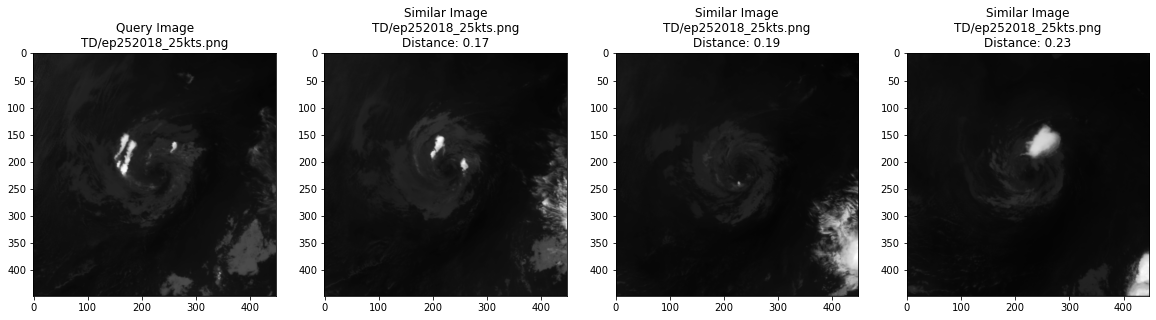

 50%|█████     | 10/20 [00:21<00:21,  2.14s/it]

1707
[ 983 1314 1699 1259 2482 1494 1613 1865  756 1391  115 2047 1294 2457
  886]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['ep102018_advTime_20180816T000000_goesTime_20180816T002107_intensity_20kts.png',
 'ep102018_advTime_20180816T060000_goesTime_20180816T112108_intensity_20kts.png',
 'ep172018_advTime_20180913T120000_goesTime_20180913T152049_intensity_30kts.png',
 'ep142018_advTime_20180828T180000_goesTime_20180828T232055_intensity_30kts.png']


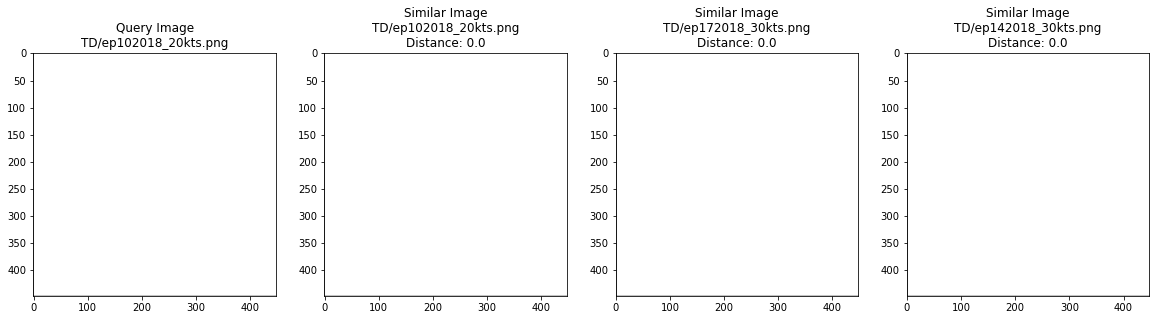

 55%|█████▌    | 11/20 [00:23<00:18,  2.08s/it]

519
[ 519 2038  732  796  221 1031  428 2319 1569 2346 2227  296 2186  816
 2131]
[0.0, 0.74, 0.81, 0.82, 0.83, 0.83, 0.83, 0.84, 0.84, 0.84, 0.86, 0.86, 0.86, 0.86, 0.86]
['al132018_advTime_20181004T120000_goesTime_20181004T172056_intensity_65kts.png',
 'al132018_advTime_20181004T120000_goesTime_20181004T152056_intensity_65kts.png',
 'al132018_advTime_20181004T120000_goesTime_20181004T142056_intensity_65kts.png',
 'al132018_advTime_20181004T180000_goesTime_20181004T202056_intensity_60kts.png']


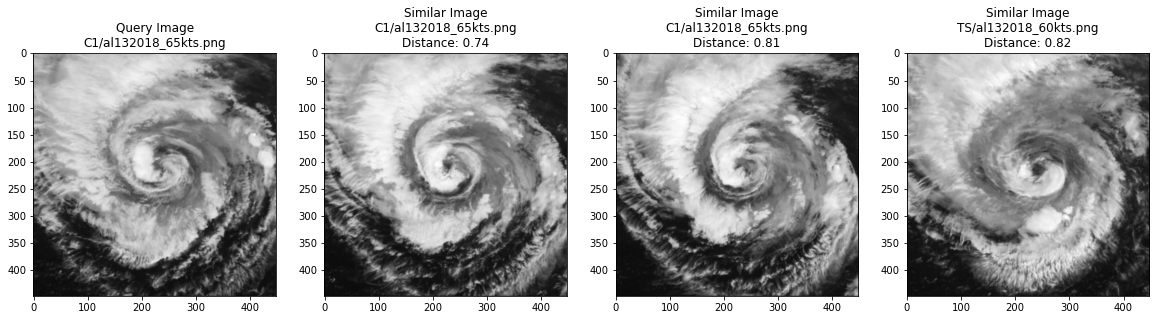

 60%|██████    | 12/20 [00:25<00:17,  2.14s/it]

2482
[ 983 1314 1699 1259 2482 1494 1613 1865  756 1391  115 2047 1294 2457
  886]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['ep102018_advTime_20180810T060000_goesTime_20180810T112105_intensity_115kts.png',
 'ep102018_advTime_20180816T060000_goesTime_20180816T112108_intensity_20kts.png',
 'ep172018_advTime_20180913T120000_goesTime_20180913T152049_intensity_30kts.png',
 'ep142018_advTime_20180828T180000_goesTime_20180828T232055_intensity_30kts.png']


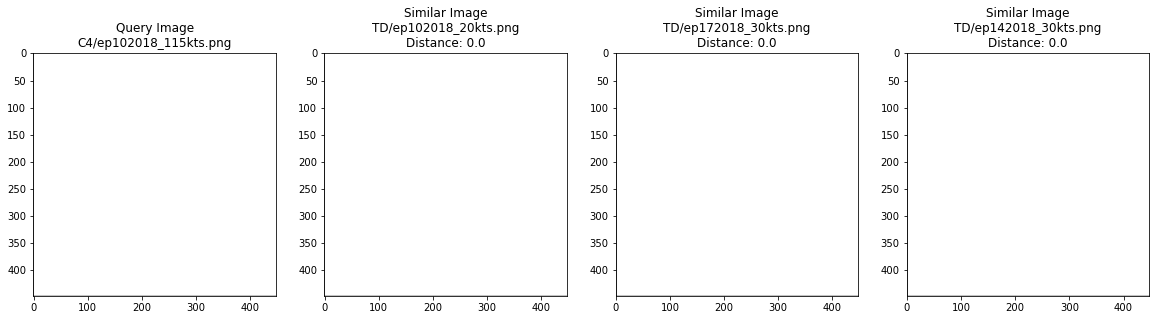

 65%|██████▌   | 13/20 [00:27<00:14,  2.07s/it]

1669
[1669 2442 2409  245 1551 1077  339 1102 1777 1160 2082 1741 2111  330
   39]
[0.0, 0.43, 0.51, 0.57, 0.65, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.67, 0.67]
['ep132019_advTime_20190918T180000_goesTime_20190918T222505_intensity_55kts.png',
 'ep132019_advTime_20190918T180000_goesTime_20190918T212505_intensity_55kts.png',
 'ep132019_advTime_20190918T180000_goesTime_20190918T202505_intensity_55kts.png',
 'ep132019_advTime_20190918T180000_goesTime_20190918T182505_intensity_55kts.png']


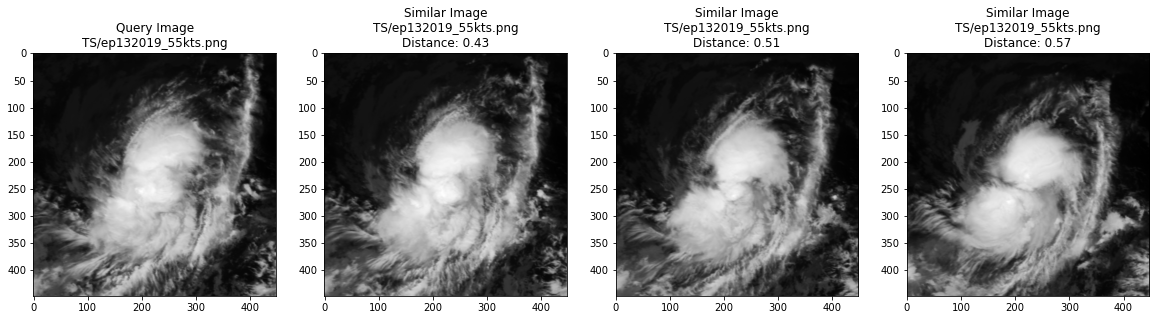

 70%|███████   | 14/20 [00:29<00:12,  2.09s/it]

211
[ 211   88 1070 1217 1858  226 1681 2127 1623 1021 2015  144  285 1569
 2288]
[0.0, 0.51, 0.62, 0.62, 0.62, 0.64, 0.64, 0.64, 0.65, 0.65, 0.65, 0.67, 0.67, 0.67, 0.67]
['ep012019_advTime_20190628T000000_goesTime_20190628T022510_intensity_65kts.png',
 'ep012019_advTime_20190628T060000_goesTime_20190628T062510_intensity_60kts.png',
 'ep162018_advTime_20180904T120000_goesTime_20180904T162054_intensity_75kts.png',
 'ep162018_advTime_20180904T120000_goesTime_20180904T172053_intensity_75kts.png']


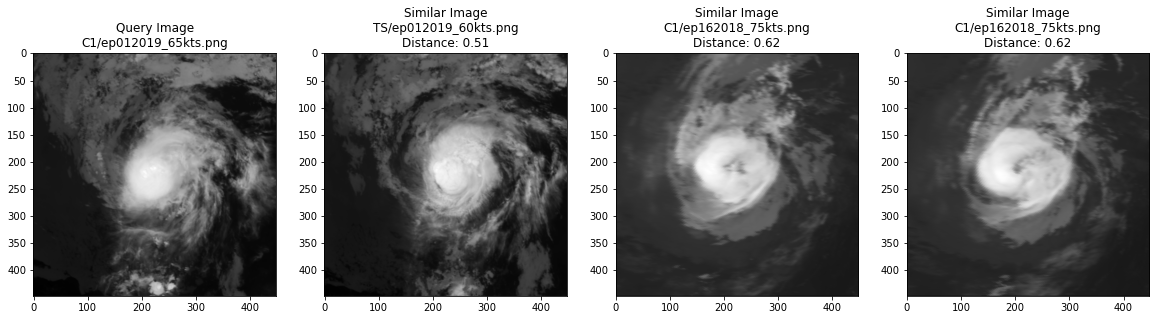

 75%|███████▌  | 15/20 [00:32<00:10,  2.09s/it]

1760
[1760 2106 2107 2040  870 1529 1399  477 2111 2082 1741  836  940  384
 1716]
[0.0, 0.4, 0.41, 0.55, 0.55, 0.56, 0.57, 0.57, 0.58, 0.58, 0.58, 0.59, 0.59, 0.61, 0.61]
['ep172018_advTime_20180906T000000_goesTime_20180906T002054_intensity_85kts.png',
 'ep172018_advTime_20180905T180000_goesTime_20180905T222054_intensity_85kts.png',
 'ep172018_advTime_20180905T180000_goesTime_20180905T212054_intensity_85kts.png',
 'ep172018_advTime_20180906T180000_goesTime_20180906T222054_intensity_110kts.png']


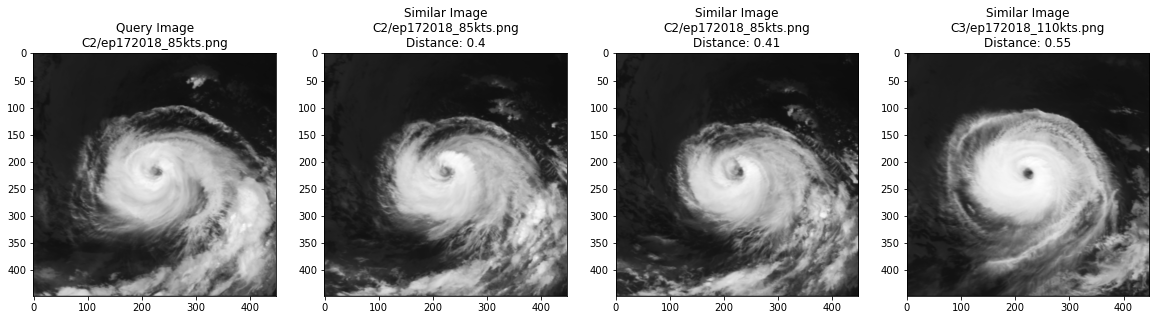

 80%|████████  | 16/20 [00:34<00:08,  2.14s/it]

2153
[2153 1869 1236 1715  655 2054  729 1813   63  397 1909  184  196  767
 1157]
[0.0, 0.31, 0.49, 0.49, 0.52, 0.52, 0.53, 0.53, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.55]
['al182019_advTime_20191028T120000_goesTime_20191028T172524_intensity_35kts.png',
 'al182019_advTime_20191028T120000_goesTime_20191028T162524_intensity_35kts.png',
 'al142018_advTime_20181013T120000_goesTime_20181013T152057_intensity_65kts.png',
 'al142018_advTime_20181013T180000_goesTime_20181013T192056_intensity_65kts.png']


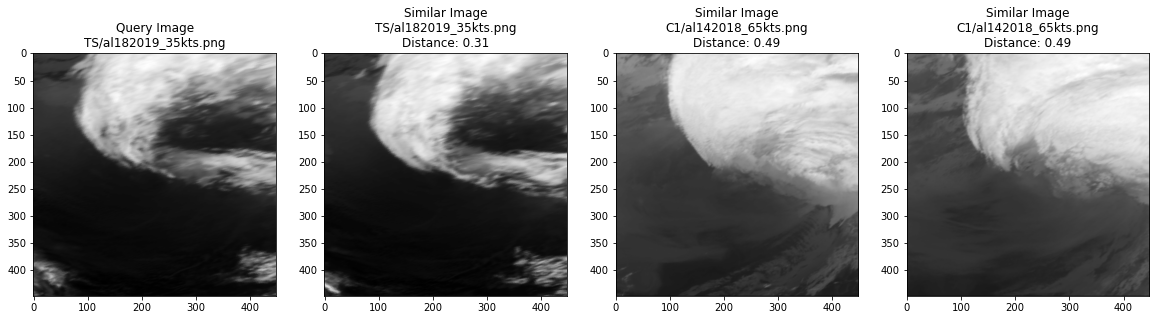

 85%|████████▌ | 17/20 [00:36<00:06,  2.12s/it]

1545
[1545 1345 1978    7  662 1695 2571 2489  701 1216 2608 1908 1098 1445
  728]
[0.0, 0.27, 0.38, 0.4, 0.41, 0.41, 0.42, 0.42, 0.42, 0.42, 0.43, 0.43, 0.44, 0.44, 0.44]
['al142019_advTime_20191011T180000_goesTime_20191011T222516_intensity_50kts.png',
 'al142019_advTime_20191011T180000_goesTime_20191011T212516_intensity_50kts.png',
 'ep072018_advTime_20180707T000000_goesTime_20180707T012100_intensity_30kts.png',
 'ep072018_advTime_20180706T180000_goesTime_20180706T212100_intensity_30kts.png']


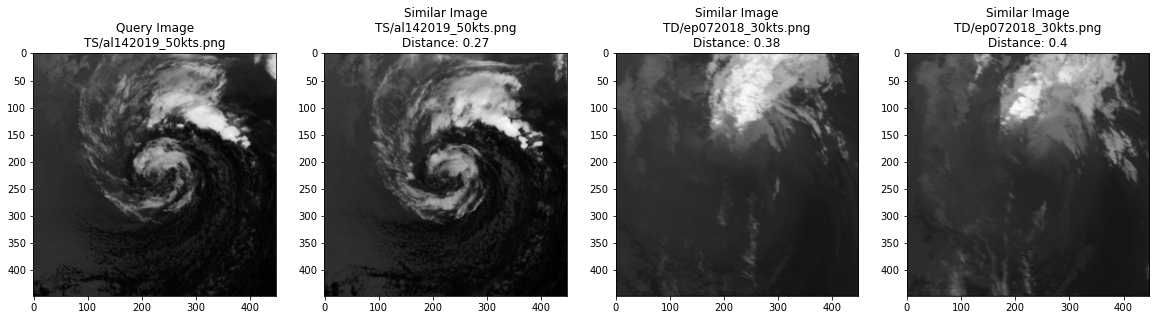

 90%|█████████ | 18/20 [00:38<00:04,  2.11s/it]

2588
[2588 1635 1579 1574  688 2294 1952 1551 2335  836 1323 1602 2345 2082
  384]
[0.0, 0.55, 0.63, 0.69, 0.69, 0.7, 0.71, 0.72, 0.73, 0.73, 0.74, 0.74, 0.74, 0.74, 0.74]
['al062018_advTime_20180901T120000_goesTime_20180901T152055_intensity_35kts.png',
 'al062018_advTime_20180901T120000_goesTime_20180901T162055_intensity_35kts.png',
 'al062018_advTime_20180901T120000_goesTime_20180901T172055_intensity_35kts.png',
 'al062018_advTime_20180901T180000_goesTime_20180901T192055_intensity_40kts.png']


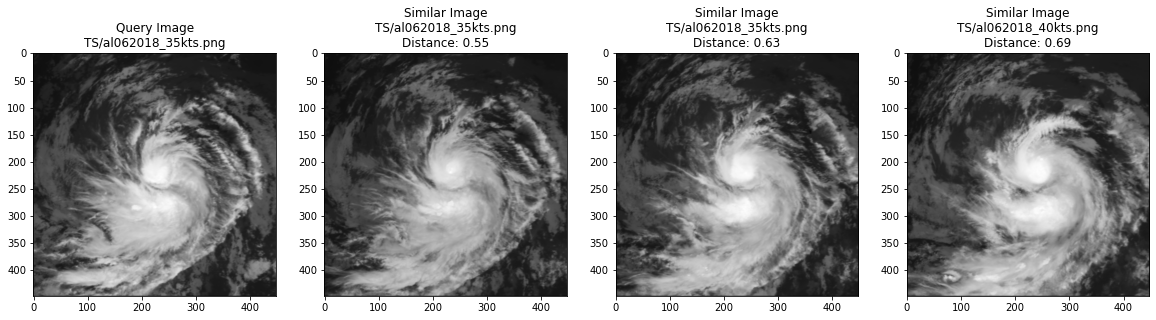

 95%|█████████▌| 19/20 [00:40<00:02,  2.13s/it]

998
[ 998 2019 2212 1269  616  279 2408 1157 1939 1470 1230 1459  655 2054
  446]
[0.0, 0.21, 0.24, 0.35, 0.35, 0.35, 0.36, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39, 0.39]
['al152019_advTime_20191017T060000_goesTime_20191017T072519_intensity_25kts.png',
 'al152019_advTime_20191017T060000_goesTime_20191017T092519_intensity_25kts.png',
 'al152019_advTime_20191017T000000_goesTime_20191017T052519_intensity_25kts.png',
 'al102018_advTime_20180916T000000_goesTime_20180916T022049_intensity_35kts.png']


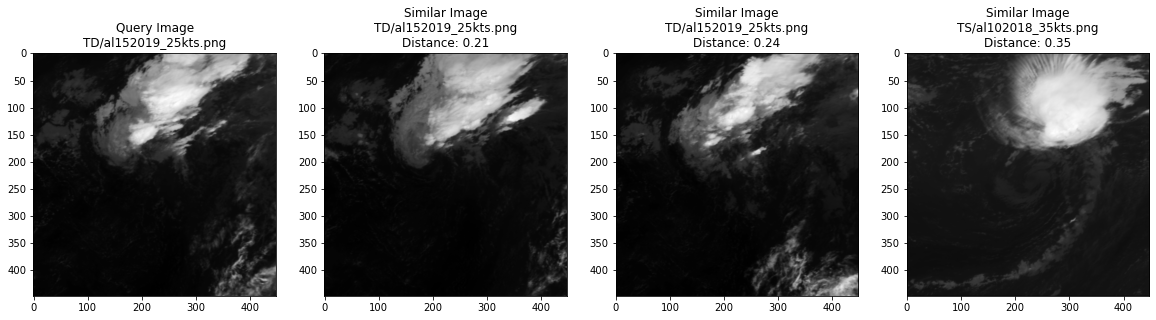

100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


In [19]:
for i in tqdm(range(20)):
    random_image_index = random.randint(0, num_images)
#     random_image_index = 142
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    print(random_image_index)
    print(indices[0][:15])
    print([float("%.2f"%d) for d in distances[0][:15]])
    
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [X_test_paths[random_image_index]] + [X_test_paths[indices[0][i]] for i in range(1, 4)]
    pprint([p.split("/")[-1] for p in similar_image_paths])
    plot_images(similar_image_paths, distances[0], dims=(448, 448, 3))
    plt.show()

In [20]:
neighbors = NearestNeighbors(n_neighbors=len(feature_list),
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors(feature_list)

# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  1.072853
Max distance between all photos:  1.7686374
Median distance among most similar photos:  0.53431594


In [21]:
selected_features = feature_list[:]
selected_class_ids = [classname(f) for f in X_test_paths[:]]
selected_filenames = X_test_paths[:]

print(len(selected_features))
print(len(selected_class_ids))
print(len(selected_filenames))

# colors = [b,g,r,c,m,y,k,w]
color_class_map = {"TD": 'b', "TS": 'g', "C1": 'r', "C2": 'c', "C3": 'm', "C4": 'y', "C5": 'k'}
selected_class_ids = [color_class_map[cid] for cid in selected_class_ids]

# print(selected_class_ids)

2623
2623
2623


In [22]:
import time
from sklearn.manifold import TSNE

# You can play with these values and see how the results change
n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(selected_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2623 samples in 0.912s...
[t-SNE] Computed neighbors for 2623 samples in 56.247s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2623
[t-SNE] Computed conditional probabilities for sample 2000 / 2623
[t-SNE] Computed conditional probabilities for sample 2623 / 2623
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.504890
[t-SNE] KL divergence after 1000 iterations: 1.121363
t-SNE done! Time elapsed: 62.086994886398315 seconds


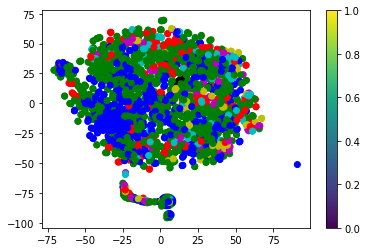

In [23]:
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class_ids,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.savefig(FEATURES_PARENT_DIR + "/tSNE_scatter.png")
plt.savefig(FEATURES_PARENT_DIR + "/tSNE_scatter.eps")
plt.show()
# To save the plot in a high definition format i.e. PDF, uncomment the following line:


In [29]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

dims=(448, 448, 3)
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        if x0 > 80:
            print("WEIIRRDDDD ===>>>>", image_path)
        image = Image.fromarray(np.uint8(resize(plt.imread((image_path))[:,:,:3], dims)*255))
#         image = Image.fromarray(np.uint8(np.load(image_path)*255))
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [30]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
#     plt.savefig(FEATURES_PARENT_DIR + "/tSNE_img_scatter.png")
#     plt.savefig(FEATURES_PARENT_DIR + "/tSNE_img_scatter.eps")
    plt.show()

WEIIRRDDDD ===>>>> /home/satyarth934/data/nasa_impact/hurricanes/ep122019/ep122019_advTime_20190905T060000_goesTime_20190905T072458_intensity_25kts.png


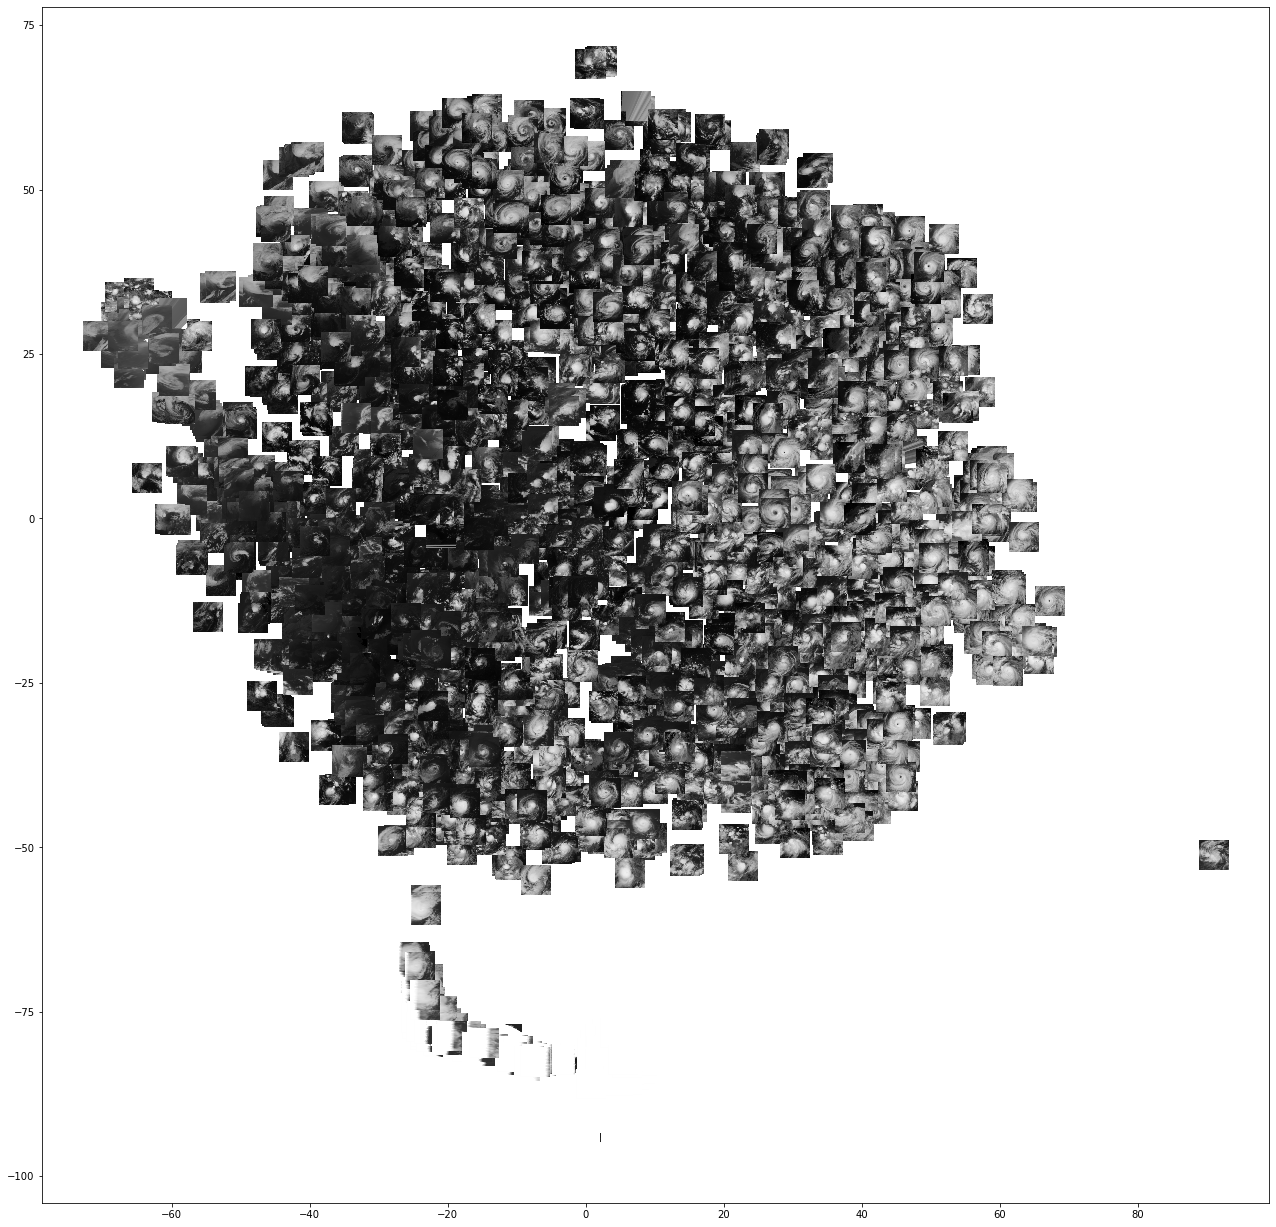

In [31]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [27]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.savefig(FEATURES_PARENT_DIR + "/tSNE_img_grid.png")
    plt.savefig(FEATURES_PARENT_DIR + "/tSNE_img_grid.eps")
    plt.show()

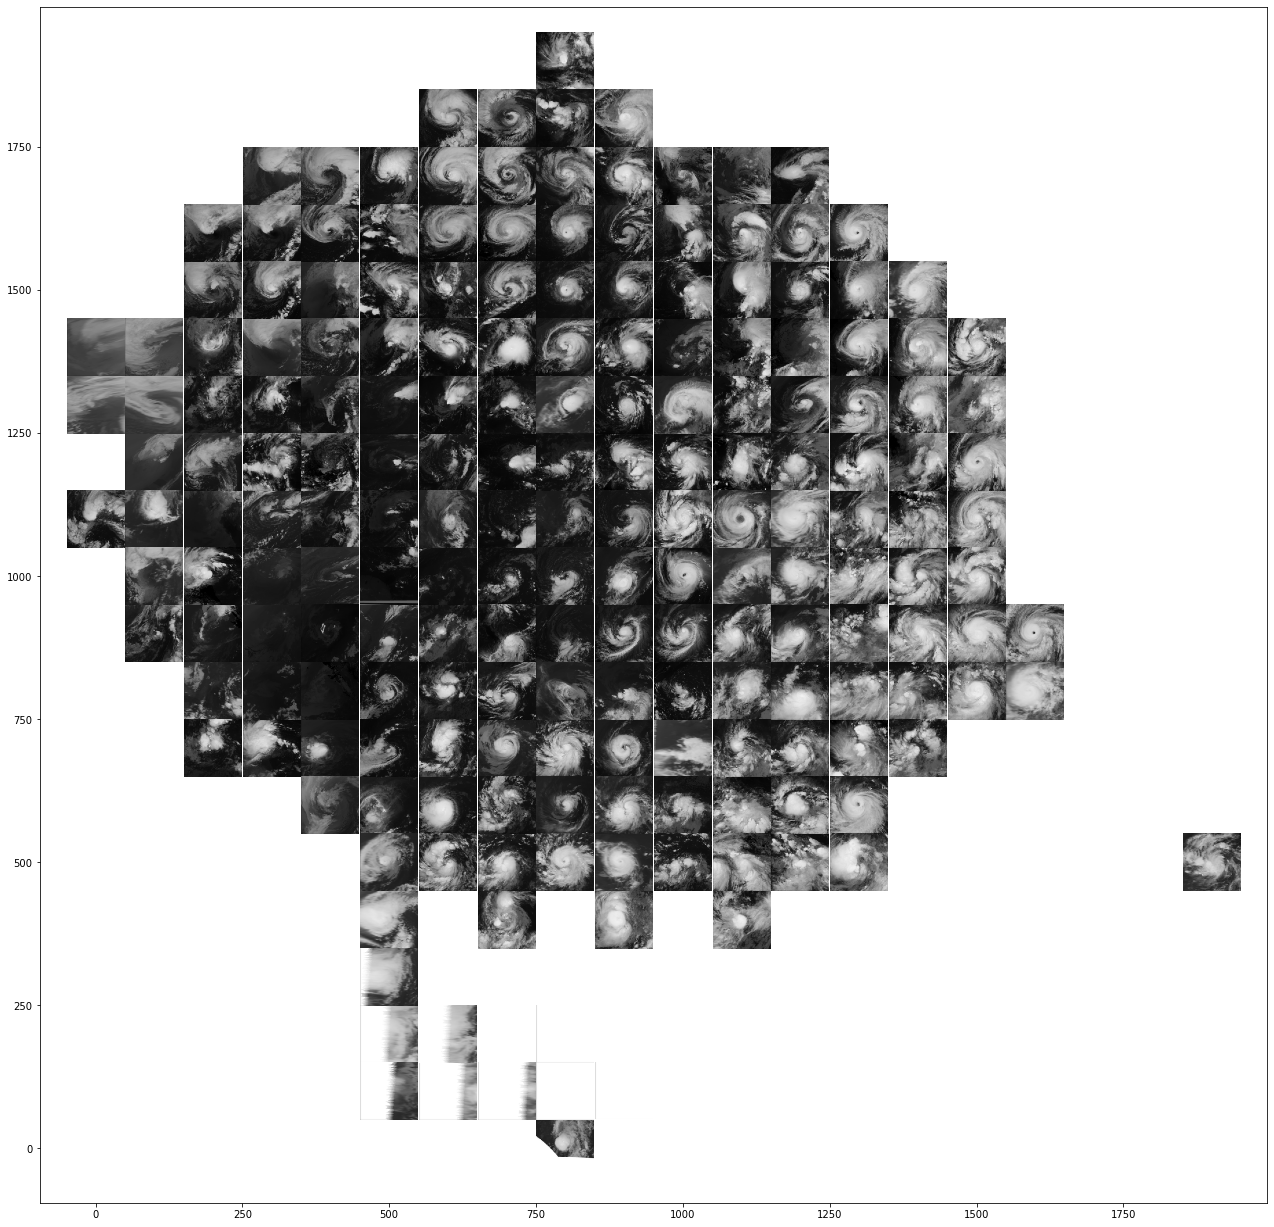

In [28]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)